In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import sys
import os
import glob
import importlib
import multiprocessing as mp
import itertools
import math
import random 

from matplotlib import pyplot as plt
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import tables
import deepdish as dd

sys.path.append('/Users/johnmarshall/Documents/MATLAB/CNMF_E_jjm/python_wrapper/')
sys.path.append('/Users/johnmarshall/caiman_data/demos/notebooks/post_cnmfe_analysis')
import python_utils_jjm as utils_jjm
import jjm_post_cnmfe_fns as jjm
import align_msCam_tobehavior as align_tracking

from importlib import reload
%matplotlib inline

In [4]:
reload(utils_jjm)

<module 'python_utils_jjm' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/caimandata/post_cmfe_analysis/python_utils_jjm.py'>

In [5]:
reload(align_tracking)

<module 'align_msCam_tobehavior' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/caimandata/post_cmfe_analysis/align_msCam_tobehavior.py'>

In [6]:
#GRIN013 
#results_file = '/Users/johnmarshall/Documents/MATLAB/29-Apr_16_52_17_wsortdecisionsout.mat'
#GRIN011 #cnmfe_analysis_files/GRIN_011
#results_file = '/Users/johnmarshall/Documents/MATLAB/04-May_00_39_45_wsortdecisions_out.mat'

results_file = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/H10_M19_S59_01242019/04-May_00_39_45_wsortdecisions_out.mat'
results = sio.loadmat(results_file)

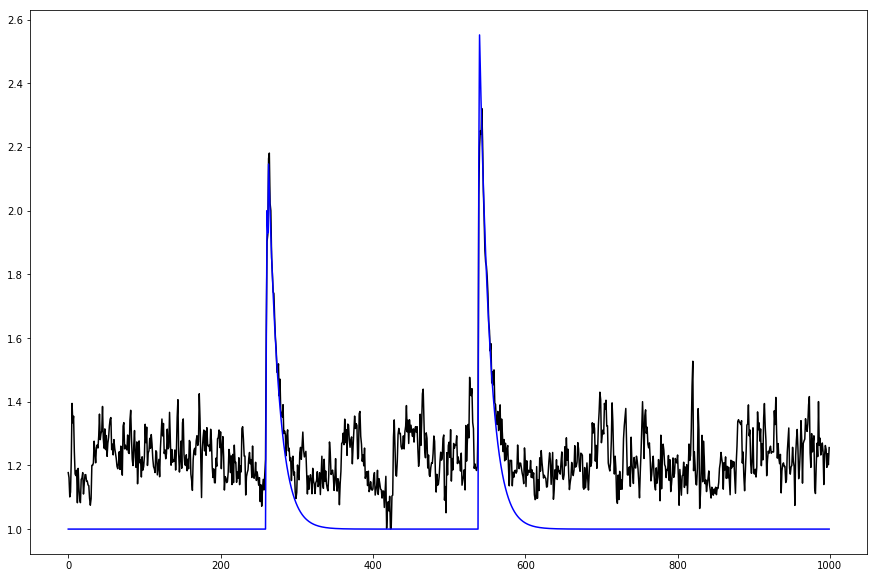

In [7]:
## Neurons to plot
# enter range or list
neurons_idx = range(1, 2)
#neurons_idx = [3, 50, 90]

# Frames to plot
frames = (9000, 10000)

# Make a plot showing some time series traces

plt.figure(figsize=(15,10))
#plt.title(name)
plt.axis('on')
        
#S = np.array(results['S'].todense())  # Inferred spikes
C = np.array(results['C'])  # Denoised fluorescence
F = np.array(results['C_raw'])  # Raw fluorescence
        
#for idx in range(np.shape(F)[0]):
for idx in neurons_idx:
    #plt.plot(utils.normalize(S[idx, frames[0]:frames[1]], percentile=False) + idx, 'r')
    #plt.plot(F[idx, frames[0]:frames[1]] + idx, 'r')
    #plt.plot(C[idx, frames[0]:frames[1]] + idx, 'g')
    
    plt.plot(utils_jjm.normalize(F[idx, frames[0]:frames[1]]) + idx, 'k')
    plt.plot(utils_jjm.normalize(C[idx, frames[0]:frames[1]]) + idx, 'b')
#    if idx > neurons_idx:
#        break

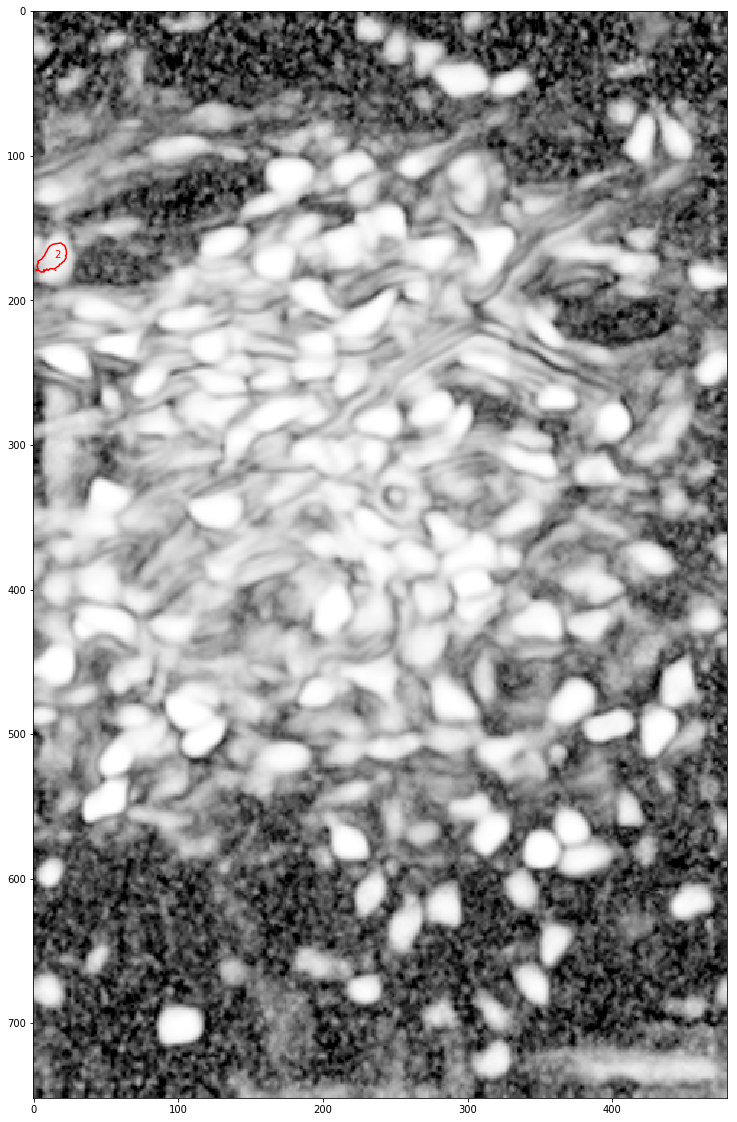

In [8]:
#coordinate of detected neurons
#should be able to input a list of coordinates to plot here 
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
coordinates = utils_jjm.plot_contours(results['A'].todense(), results['Cn'], list_to_plot=neurons_idx, display_numbers=True, maxthr=.6,cmap='gray', colors='r')

In [28]:
##load movement data and align to cnmfe output

path_to_eztrackfiles = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/H10_M19_S59_01242019/behavior_tracking_data/'
miniscope_time_stamp_file = path_to_eztrackfiles+'timestamp.dat'
location_files = glob.glob(path_to_eztrackfiles+'*_LocationOutput.csv')

dfs = []
for file in location_files:
     dfs.append(pd.read_csv(file, usecols=[1,9,10,11]))

tracking_concacted = pd.concat(dfs)

aligned_ = align_tracking.align_and_return_ezTrack(tracking_concacted, miniscope_time_stamp_file, 26000)
#plt.plot(aligned_['sys_clocks_behavCam']/(1000*60), aligned_['velocity'])


 14%|█▎        | 3557/25999 [00:14<01:34, 236.95it/s]


 27%|██▋       | 7001/25999 [00:29<01:23, 227.98it/s]


 39%|███▉      | 10266/25999 [00:44<01:12, 217.17it/s]


 51%|█████     | 13191/25999 [00:59<01:04, 198.60it/s]


 62%|██████▏   | 16107/25999 [01:14<00:47, 206.63it/s]


 74%|███████▍  | 19324/25999 [01:28<00:29, 228.55it/s]


 87%|████████▋ | 22660/25999 [01:43<00:14, 236.89it/s]


100%|█████████▉| 25933/25999 [01:58<00:00, 221.94it/s]

KeyError: 25951


100%|█████████▉| 25933/25999 [02:17<00:00, 221.94it/s]

In [10]:
## z score velocity trace 
# change infinity values to zero for now
velocity = aligned_['velocity'].values
velocity[velocity == np.inf] = 0
velocity_zscore = stats.zscore(velocity)


In [25]:
aligned_

,camNum,sysClock,buffer,velocity,Distance,behavCam_frames,msCam_frames,sys_clocks_behavCam
frameNum,,,,,,,,
1,0,0,1,0.000000,0.000000,1,1,0.0
2,0,49,1,176.496681,5.647894,2,2,33.0
3,0,102,1,9.335973,0.308087,4,3,99.0
4,0,155,1,4.561811,0.141416,6,4,164.0
5,0,208,1,7.415769,0.237305,7,5,196.0
6,0,256,1,3.264849,0.107740,9,6,260.0
7,0,303,1,9.932350,0.317835,10,7,292.0
8,0,351,1,7.652850,0.244891,12,8,354.0
9,0,405,1,2.257832,0.110634,13,9,403.0


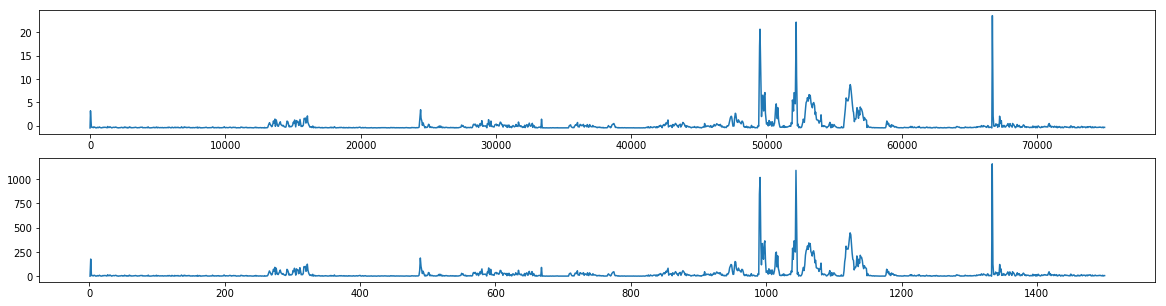

In [24]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(2,1,1)
plt.plot(aligned_['sys_clocks_behavCam'][0:1500], velocity_zscore[0:1500])
plt.subplot(2,1,2)
plt.plot(aligned_['velocity'][0:1500])

In [ ]:
## align fluorescence events to threshold crossing
event_count, sample_points = align_tracking.count_events_in_array_threshold(velocity_zscore, 30, 0, threshold=5, up=True)
# generate radom points for comparsion
random_points = random.sample(range(1, 29000), len(sample_points))
# velocity
velocity_averaged = align_tracking.return_triggered_events(velocity, sample_points, (300,300))
velocity_averaged_random = align_tracking.return_triggered_events(velocity, random_points, (300,300))
# denoised fluorescence 
C_mean = np.mean(C, axis=0)
denoised_fluorescence_averaged = align_tracking.return_triggered_events(C_mean, sample_points, (300,300))
denoised_fluorescence_averaged_random = align_tracking.return_triggered_events(C_mean, random_points, (300,300))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(velocity_averaged.mean(axis=1))
plt.subplot(2, 1, 2)
plt.plot(denoised_fluorescence_averaged.mean(axis=1))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(velocity_averaged_random.mean(axis=1))
plt.subplot(2, 1, 2)
plt.plot(denoised_fluorescence_averaged_random.mean(axis=1))

In [ ]:
## save output 
dd.io.save(results_file.rstrip('.mat')+'t.h5', {'C':results['C'],'C_raw':results['C_raw'],'A':results['A'], 'S':results['S'], 'behavior_info':aligned_.to_dict()})

In [ ]:
## should 1st Z - score velocity 

In [ ]:
num_neurons = np.shape(C)[0]

In [ ]:
## calculate distribution of correlation coefficents with velocity 
num_neurons = np.shape(C)[0]
behav_correlations = []
for neuron in range(1,num_neurons):
    r = stats.pearsonr(velocity_zscore, results['C'][neuron])[0]
    behav_correlations.append(r)

In [ ]:
hist_, bin_edges_ = np.histogram(behav_correlations, bins='auto')
plt.hist(behav_correlations, bins='auto')
plt.show()

In [ ]:
## calculate pairwise correlation coefficients
num_neurons = np.shape(C)[0]
pairwise = {}
for pair in itertools.combinations(range(num_neurons),2):
    #pairwise correlation coefficient
    r = stats.pearsonr(results['C'][pair[0]], results['C'][pair[1]])[0]
    #euclidian distance 
    distance = dist.euclidean(coordinates[pair[0]]['CoM'], coordinates[pair[1]]['CoM'])
    pairwise[pair] = (r, distance)

In [ ]:
pairwise[(0, 1)][0]

In [ ]:
r_coeffs = [pairwise[pair][0] for pair in list(pairwise.keys())]
distance = [pairwise[pair][1] for pair in list(pairwise.keys())]

In [ ]:
hist_, bin_edges_ = np.histogram(r_coeffs, bins='auto')
plt.hist(r_coeffs, bins='auto')
plt.show()

In [ ]:
plt.scatter(distance, r_coeffs)
plt.show()

In [ ]:
##save pairwise comparisons as hdf5 file 
pairwise_df = pd.DataFrame(pairwise)
pairwise_df.to_hdf('/Users/johnmarshall/Documents/MATLAB/29-Apr_16_52_17_pairwise_distance_comparisons.h5', key='df', mode='w', complevel=5)